# Earnings Calendar Analysis

Visualize historical earnings calendar to understand:
- Daily earnings volume over time
- Seasonal patterns (earnings seasons)
- Day-of-week and monthly distributions
- Year-over-year consistency

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

DATA_DIR = Path('../data/earnings')

In [2]:
# Load historical earnings data
df = pd.read_parquet(DATA_DIR / 'historical_earnings_moves.parquet')
df['earnings_date'] = pd.to_datetime(df['earnings_date'])

print(f"Total earnings events: {len(df):,}")
print(f"Unique symbols: {df['symbol'].nunique():,}")
print(f"Date range: {df['earnings_date'].min().date()} to {df['earnings_date'].max().date()}")

Total earnings events: 73,659
Unique symbols: 4,289
Date range: 2021-01-14 to 2025-12-18


## Daily Earnings Count Over Time

Time series showing number of earnings announcements per day, with 7-day rolling average to show trend.

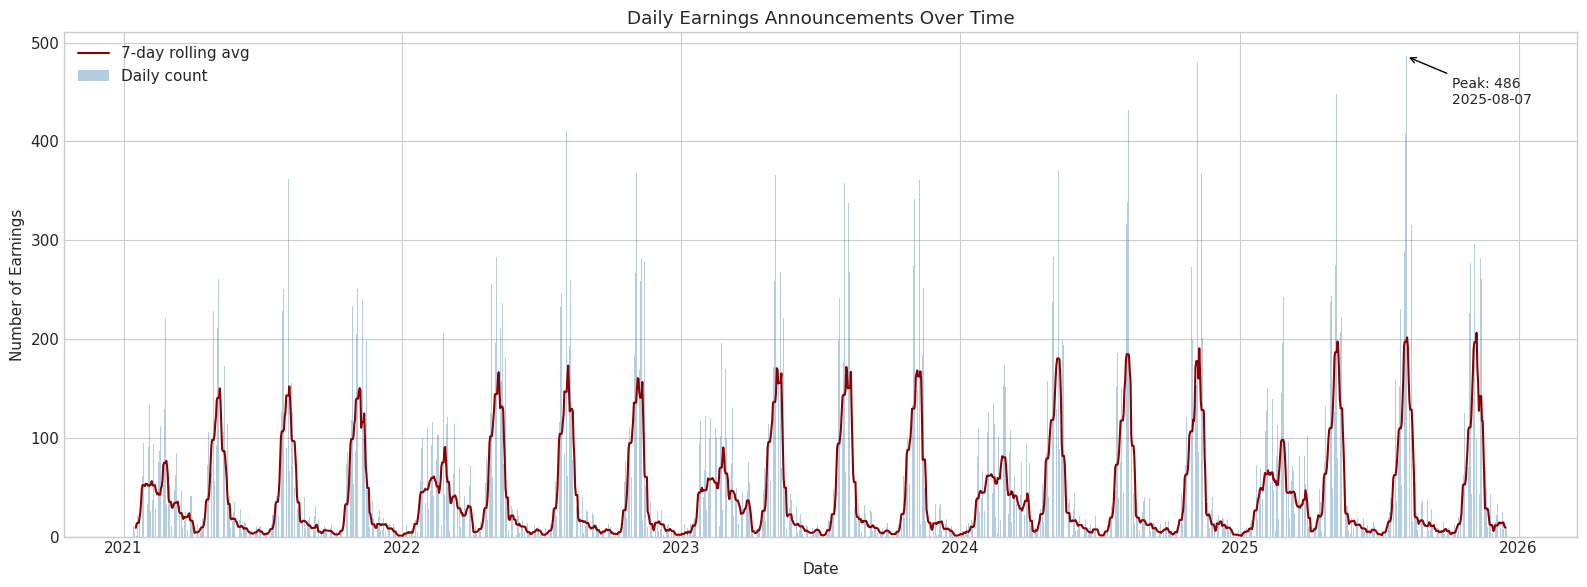


Peak day: 2025-08-07 with 486 earnings
Average daily earnings (trading days only): 59.2


In [3]:
# Daily earnings count
daily_counts = df.groupby('earnings_date').size().reset_index(name='count')
daily_counts = daily_counts.set_index('earnings_date')

# Reindex to include all dates (fill missing with 0)
full_date_range = pd.date_range(daily_counts.index.min(), daily_counts.index.max(), freq='D')
daily_counts = daily_counts.reindex(full_date_range, fill_value=0)
daily_counts['rolling_7d'] = daily_counts['count'].rolling(7, center=True).mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(daily_counts.index, daily_counts['count'], alpha=0.4, color='steelblue', label='Daily count')
ax.plot(daily_counts.index, daily_counts['rolling_7d'], color='darkred', linewidth=1.5, label='7-day rolling avg')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Earnings')
ax.set_title('Daily Earnings Announcements Over Time')
ax.legend()

# Annotate peak
peak_idx = daily_counts['count'].idxmax()
peak_val = daily_counts.loc[peak_idx, 'count']
ax.annotate(f'Peak: {peak_val:.0f}\n{peak_idx.strftime("%Y-%m-%d")}', 
            xy=(peak_idx, peak_val), xytext=(peak_idx + pd.Timedelta(days=60), peak_val * 0.9),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nPeak day: {peak_idx.date()} with {peak_val:.0f} earnings")
print(f"Average daily earnings (trading days only): {daily_counts[daily_counts['count'] > 0]['count'].mean():.1f}")

## Monthly Distribution

Earnings are heavily concentrated in "earnings season" months following quarter-ends:
- Jan/Feb (Q4 results)
- Apr/May (Q1 results)  
- Jul/Aug (Q2 results)
- Oct/Nov (Q3 results)

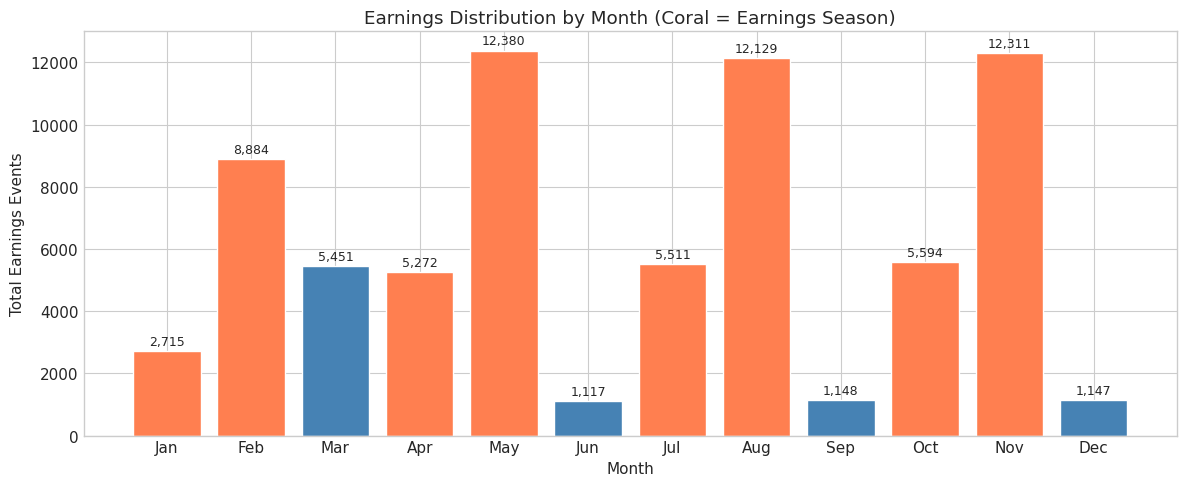


Earnings season months account for 88.0% of all earnings


In [4]:
# Monthly distribution
df['month'] = df['earnings_date'].dt.month
monthly_counts = df.groupby('month').size()

# Earnings season months
earnings_season = [1, 2, 4, 5, 7, 8, 10, 11]
colors = ['coral' if m in earnings_season else 'steelblue' for m in range(1, 13)]

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(monthly_counts.index, monthly_counts.values, color=colors, edgecolor='white')

ax.set_xlabel('Month')
ax.set_ylabel('Total Earnings Events')
ax.set_title('Earnings Distribution by Month (Coral = Earnings Season)')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add count labels
for bar, count in zip(bars, monthly_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
            f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

season_pct = monthly_counts[earnings_season].sum() / monthly_counts.sum() * 100
print(f"\nEarnings season months account for {season_pct:.1f}% of all earnings")

## Day of Week Distribution

Most companies report on Tuesday-Thursday, avoiding Monday (post-weekend news cycle) and Friday (pre-weekend burial).

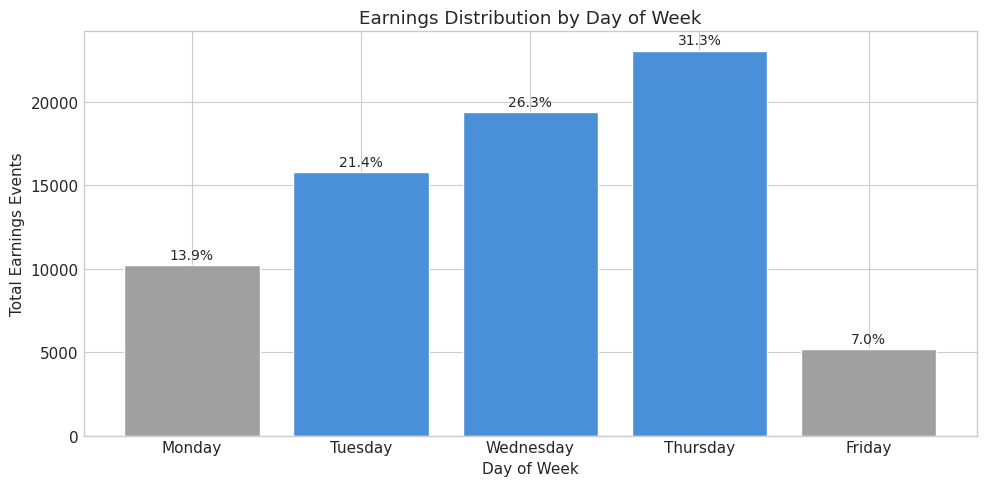


Tue-Wed-Thu accounts for 79.1% of all earnings


In [5]:
# Day of week distribution
df['day_of_week'] = df['earnings_date'].dt.dayofweek
dow_counts = df.groupby('day_of_week').size()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors_dow = ['#4a90d9' if d in [1, 2, 3] else '#a0a0a0' for d in range(7)]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar([day_names[i] for i in dow_counts.index], dow_counts.values, 
              color=[colors_dow[i] for i in dow_counts.index], edgecolor='white')

ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Earnings Events')
ax.set_title('Earnings Distribution by Day of Week')

# Add percentage labels
total = dow_counts.sum()
for bar, count in zip(bars, dow_counts.values):
    pct = count / total * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

tue_thu_pct = dow_counts[[1, 2, 3]].sum() / total * 100
print(f"\nTue-Wed-Thu accounts for {tue_thu_pct:.1f}% of all earnings")

## Weekly Heatmap by Week of Year

Shows earnings intensity by week number and day of week - visualizes the quarterly "earnings waves".

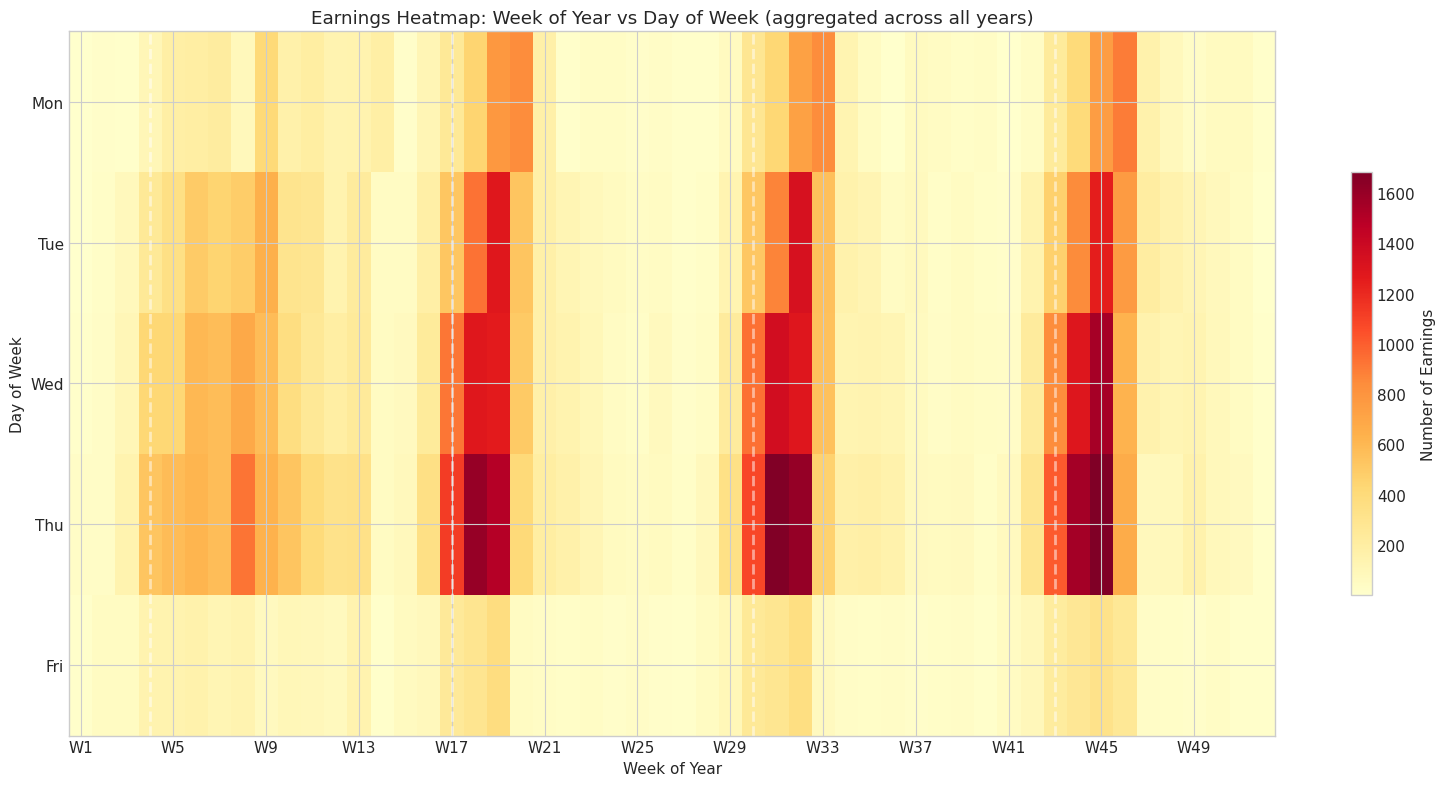

In [6]:
# Heatmap: week of year vs day of week
df['week_of_year'] = df['earnings_date'].dt.isocalendar().week

heatmap_data = df.groupby(['week_of_year', 'day_of_week']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(heatmap_data.T.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')

ax.set_xlabel('Week of Year')
ax.set_ylabel('Day of Week')
ax.set_title('Earnings Heatmap: Week of Year vs Day of Week (aggregated across all years)')

ax.set_xticks(range(0, len(heatmap_data), 4))
ax.set_xticklabels([f'W{w}' for w in heatmap_data.index[::4]])
ax.set_yticks(range(5))
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])

plt.colorbar(im, ax=ax, label='Number of Earnings', shrink=0.6)

# Mark approximate earnings season weeks
for week_start in [4, 17, 30, 43]:  # Approximate Q report weeks
    ax.axvline(x=week_start - heatmap_data.index.min(), color='white', linestyle='--', alpha=0.5, linewidth=2)

plt.tight_layout()
plt.show()

## Year-over-Year Comparison

Compare earnings patterns across years to see consistency of the seasonal pattern.

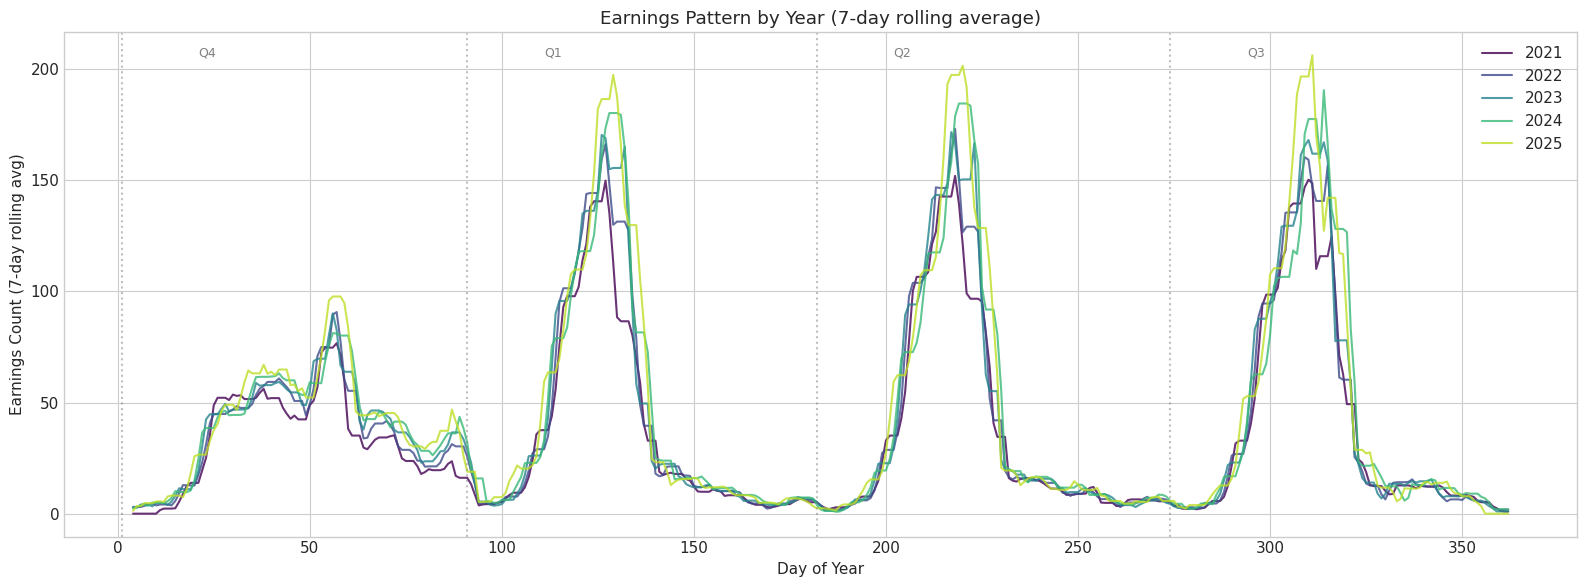

In [7]:
# Year-over-year comparison
df['year'] = df['earnings_date'].dt.year
df['day_of_year'] = df['earnings_date'].dt.dayofyear

years = sorted(df['year'].unique())
colors_year = plt.cm.viridis(np.linspace(0, 0.9, len(years)))

fig, ax = plt.subplots(figsize=(16, 6))

for year, color in zip(years, colors_year):
    year_data = df[df['year'] == year].groupby('day_of_year').size()
    # Rolling average for smoother lines
    year_rolling = year_data.reindex(range(1, 366), fill_value=0).rolling(7, center=True).mean()
    ax.plot(year_rolling.index, year_rolling.values, label=str(year), color=color, alpha=0.8, linewidth=1.5)

ax.set_xlabel('Day of Year')
ax.set_ylabel('Earnings Count (7-day rolling avg)')
ax.set_title('Earnings Pattern by Year (7-day rolling average)')
ax.legend(loc='upper right')

# Mark quarters
for day, label in [(1, 'Q4'), (91, 'Q1'), (182, 'Q2'), (274, 'Q3')]:
    ax.axvline(x=day, color='gray', linestyle=':', alpha=0.5)
    ax.text(day + 20, ax.get_ylim()[1] * 0.95, label, fontsize=9, color='gray')

plt.tight_layout()
plt.show()

## Summary Statistics by Year

In [8]:
# Yearly summary
yearly_stats = df.groupby('year').agg(
    total_earnings=('symbol', 'count'),
    unique_symbols=('symbol', 'nunique'),
    peak_day_count=('earnings_date', lambda x: x.value_counts().max()),
    avg_per_day=('earnings_date', lambda x: len(x) / x.dt.dayofyear.max())
).round(1)

print("Yearly Earnings Summary:")
print("=" * 60)
print(yearly_stats.to_string())

Yearly Earnings Summary:
      total_earnings  unique_symbols  peak_day_count  avg_per_day
year                                                             
2021           12960            3518             369         35.6
2022           14164            3689             410         38.9
2023           14805            3839             366         40.8
2024           15512            4031             480         42.4
2025           16218            4238             486         46.1


## Peak Earnings Days

The busiest days for earnings announcements.

In [9]:
# Top 20 busiest earnings days
top_days = df.groupby('earnings_date').size().sort_values(ascending=False).head(20)

print("Top 20 Busiest Earnings Days:")
print("=" * 40)
for date, count in top_days.items():
    print(f"{date.strftime('%Y-%m-%d')} ({date.strftime('%A')[:3]}): {count:>4} earnings")

Top 20 Busiest Earnings Days:
2025-08-07 (Thu):  486 earnings
2024-11-07 (Thu):  480 earnings
2025-11-06 (Thu):  462 earnings
2025-05-08 (Thu):  448 earnings
2024-08-08 (Thu):  432 earnings
2022-08-04 (Thu):  410 earnings
2025-08-06 (Wed):  407 earnings
2025-11-05 (Wed):  381 earnings
2025-05-07 (Wed):  377 earnings
2024-05-09 (Thu):  371 earnings
2024-11-06 (Wed):  370 earnings
2021-11-04 (Thu):  369 earnings
2024-05-08 (Wed):  368 earnings
2022-11-03 (Thu):  368 earnings
2024-11-12 (Tue):  367 earnings
2023-05-04 (Thu):  366 earnings
2022-05-05 (Thu):  364 earnings
2021-08-05 (Thu):  362 earnings
2023-11-09 (Thu):  361 earnings
2023-08-03 (Thu):  358 earnings


## BMO vs AMC Timing Distribution

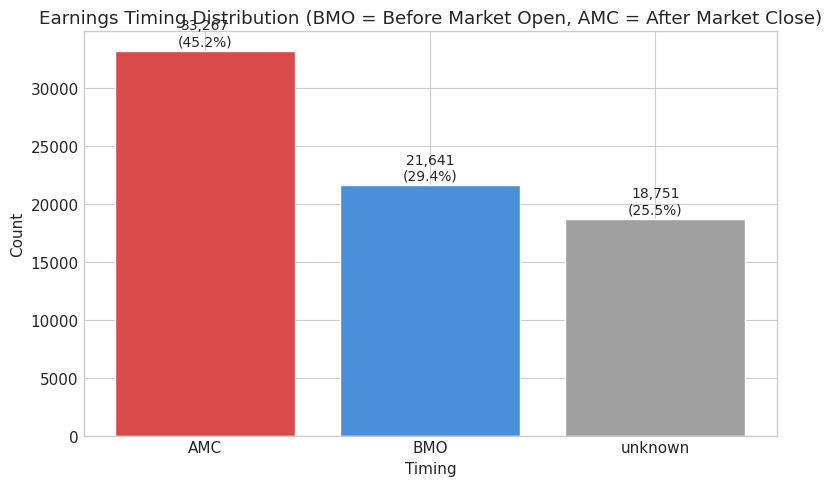

In [10]:
# Timing distribution
if 'timing' in df.columns:
    timing_counts = df['timing'].value_counts()
    
    fig, ax = plt.subplots(figsize=(8, 5))
    colors_timing = {'BMO': '#4a90d9', 'AMC': '#d94a4a', 'unknown': '#a0a0a0'}
    bars = ax.bar(timing_counts.index, timing_counts.values, 
                  color=[colors_timing.get(t, '#a0a0a0') for t in timing_counts.index],
                  edgecolor='white')
    
    ax.set_xlabel('Timing')
    ax.set_ylabel('Count')
    ax.set_title('Earnings Timing Distribution (BMO = Before Market Open, AMC = After Market Close)')
    
    # Add percentage labels
    total = timing_counts.sum()
    for bar, count in zip(bars, timing_counts.values):
        pct = count / total * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("Timing column not available in dataset")